# Analysis of "Harry Potter and the Goblet of fire"

For our analysis, we chose the fourth novel in the "Harry Potter" series written by J.K. Rowling. To analyze the text we mainly use "nltk" library for language and sentiment analysis, as well as 'networkx' to visualize the connections between characters. 

We found and downloaded the book as pdf file from this site: https://www.info24service.com/wp-content/uploads/4-Harry-Potter-and-the-Goblet-of-Fire_US_ISBN-0-439-13959-7_2014-191-1447.pdf

First we load all needed libraries.

In [182]:
import PyPDF2
import re
import nltk
import datetime
import random
import requests
import warnings
import itertools
import numpy as np
import matplotlib.image as mpimg
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from pylab import rcParams
from matplotlib.cm import ScalarMappable
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from io import BytesIO
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
warnings.filterwarnings('ignore')

We use 'PyPDF2' library to load the book into python.

In [183]:
pdfFileObj = open("book.pdf", 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

We define two functions for cleaning the text. One of them leave only letters, and the second letters and some special characters.

In [184]:
def clean_text(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text


def clean_text_with_special(text):
    text = re.sub('[^A-Za-z!?.]+', ' ', text)
    return text

To analyze the book first we focus on most common keywords and sentiment analysis.

To get top keywords we use 'nltk' package.

In [185]:
def _get_whole_book():
    text = ""
    for i in range(750):
        pageObj = pdfReader.getPage(i)
        text += pageObj.extractText()

    return text


def get_top_kw(n):
    text = clean_text(_get_whole_book())
    all_words = nltk.tokenize.word_tokenize(text)
    stop_words = nltk.corpus.stopwords.words('english')
    all_without_stop = nltk.FreqDist(w.lower() for w in all_words if w not in stop_words)
    most_common = all_without_stop.most_common(n)
    return most_common

In [186]:
get_top_kw(20)

[('harry', 3102),
 ('said', 2608),
 ('i', 2135),
 ('he', 1149),
 ('the', 1054),
 ('ron', 1031),
 ('hermione', 815),
 ('back', 586),
 ('one', 548),
 ('mr', 538),
 ('dumbledore', 523),
 ('around', 475),
 ('looked', 471),
 ('you', 465),
 ('it', 458),
 ('could', 441),
 ('like', 440),
 ('got', 417),
 ('though', 412),
 ('would', 400)]

Above we can see 20 most common word with mixed types. We observe some key characters, like Harry, Ron, Hermione and Dumbledore.

In [187]:
def get_top_kw_of_category(list_of_tags, n=40):
    text = clean_text(_get_whole_book())
    tokens = nltk.tokenize.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens, tagset='universal')
    words = [token[0] for token in tagged_tokens if token[1] in list_of_tags]
    frequency = nltk.FreqDist(words).most_common(n)
    freq_dict = {}
    for t in frequency:
        freq_dict[t[0]] = t[1]
    return freq_dict

To visualize these keywords, we define function for wordcloud.

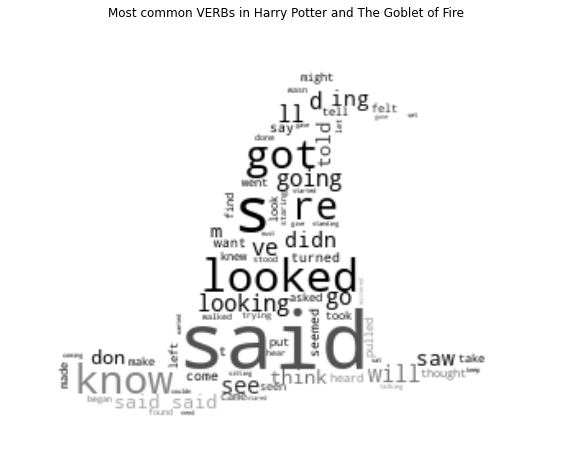

In [188]:
def word_cloud(text, image_name, maxsize,
               maxwords, title, figsize):
    stopwords = set(STOPWORDS)
    mask = np.array(Image.open(image_name))
    wordcloud = WordCloud(stopwords=stopwords,
                          background_color="white", max_words=maxwords, max_font_size=maxsize, mask=mask).generate(text)
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[figsize, figsize])
    plt.title(title)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

def make_text_for_wordcloud(list_of_tags):
    mentions_dict = get_top_kw_of_category(list_of_tags, n=300)
    text = ""
    for word, count in mentions_dict.items():
        text += (word+"  ")*count

    text = text.split("  ")
    random.shuffle(text)
    text = "  ".join(text)
    return text

text = make_text_for_wordcloud('VERB')
word_cloud(text, "hat.jpg",
          200, 70000, "Most common VERBs in Harry Potter and The Goblet of Fire", 10)

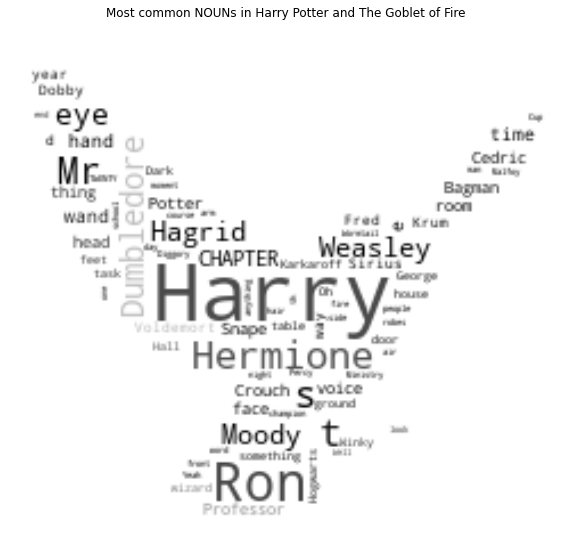

In [189]:
text = make_text_for_wordcloud('NOUN')
word_cloud(text, "hedwig.png",
          200, 70000, "Most common NOUNs in Harry Potter and The Goblet of Fire", 10)

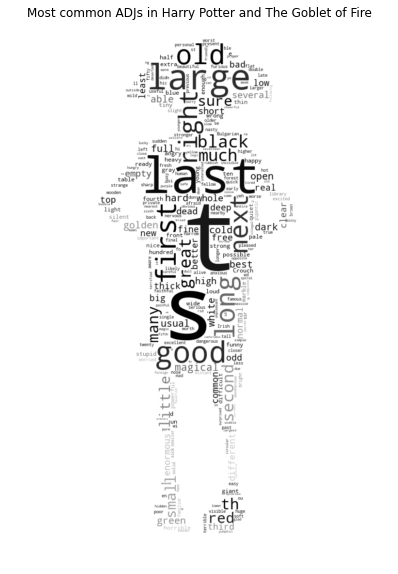

In [190]:
text = make_text_for_wordcloud('ADJ')
word_cloud(text, "dobby.jpeg",
          200, 70000, "Most common ADJs in Harry Potter and The Goblet of Fire", 10)

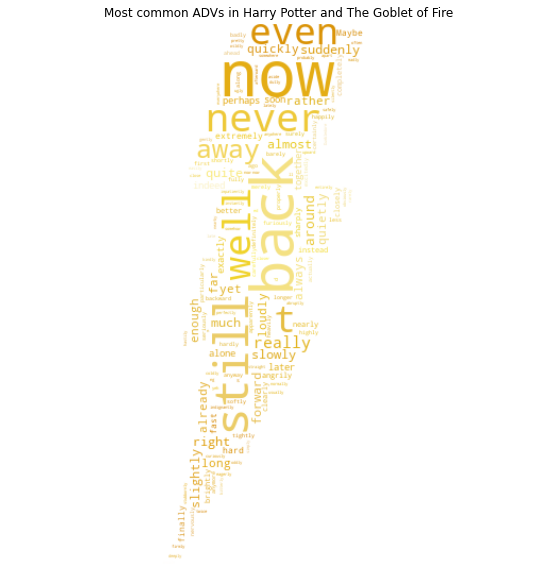

In [191]:
text = make_text_for_wordcloud('ADV')
word_cloud(text, "lightning.jpeg",
          200, 70000, "Most common ADVs in Harry Potter and The Goblet of Fire", 10)

## Sentiment analysis

Next we will analyze sentiment of the pages.

In [192]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}


def change_tags(page):
    word, tag = page[0], page[1]
    return tuple([word, pos_dict.get(tag[0])])


def lemmatize(page):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_rew = " "
    for word, pos in page:
        if not pos:
            lemma_rew = lemma_rew + " " + word
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma

    return lemma_rew


def remove_stopwords(words):
    return [i for i in words if i.lower() not in stopwords.words('english')]


def polarity(comment):
    return TextBlob(comment).sentiment.polarity


def get_pol_interpretation(num):
    return 'positive' if num>=0.35 else 'negative' if num<=-0.35 else 'neutral'

First we use 'nltk' library.

In [193]:
def sentiment_pages():
    sentiment_per_page = {}
    for i in range(750):
        pageObj = pdfReader.getPage(i)
        ex = clean_text_with_special(pageObj.extractText())
        tokenized_wo_stopwords = remove_stopwords(word_tokenize(ex))
        tagged = pos_tag(tokenized_wo_stopwords)
        changed = [change_tags(i) for i in tagged]
        lemmatized = lemmatize(changed)
        sentiment_per_page[i] = get_pol_interpretation(polarity(lemmatized))
    return sentiment_per_page

In [194]:
sentiment_nltk = sentiment_pages()
counter = Counter(sentiment_nltk.values())
counter

Counter({'neutral': 744, 'positive': 5, 'negative': 1})

Next we want to compare 'nltk' results with 'vaderSentiment' package.

In [195]:
def get_all_characters(char_per_page):
    all = []
    for char_list in char_per_page.values():
        all.extend(char_list)
    return set(all)


def get_pol_interpretation(num):
    return 'positive' if num >= 0.35 else 'negative' if num <= -0.35 else 'neutral'


def get_v_pol_interpretation(num):
    return 'positive' if num >= 0.5 else 'negative' if num <= -0.5 else 'neutral'


def vader_sentiment(page):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(page)['compound']

def vader_sentiment_pages():
    sentiment_per_page = {}
    for i in range(750):
        pageObj = pdfReader.getPage(i)
        ex = clean_text_with_special(pageObj.extractText())
        tokenized_wo_stopwords = remove_stopwords(word_tokenize(ex))
        tagged = pos_tag(tokenized_wo_stopwords)
        changed = [change_tags(i) for i in tagged]
        lemmatized = lemmatize(changed)
        sentiment_per_page[i] = get_v_pol_interpretation(vader_sentiment(lemmatized))
    return sentiment_per_page


sentiment_dict = vader_sentiment_pages()


def get_most_common_per_sentiment(sentiment_dict):
    words_per_sent = _get_text_per_sentiment()
    freq_per_sent = {i: "" for i in sentiment_dict.values()}
    stop_words = nltk.corpus.stopwords.words('english')
    people = get_all_characters(char_per_page)
    for sentiment, words in words_per_sent.items():
        freq_per_sent[sentiment] = nltk.FreqDist([w for w in words.split(" ") if all([w not in stop_words,
                                                                                     w not in people])]).most_common(15)
    return freq_per_sent

def _get_text_per_sentiment():
    words_per_sent = {i: "" for i in sentiment_dict.values()}
    for i in range(750):
        pageObj = pdfReader.getPage(i)
        page_sentiment = sentiment_dict[i]
        words_per_sent[page_sentiment] += clean_text(pageObj.extractText())

    return words_per_sent


print(get_most_common_per_sentiment(sentiment_dict))

{'neutral': [('said', 226), ('I', 162), ('He', 139), ('The', 85), ('Ron', 81), ('Mr', 60), ('could', 55), ('back', 52), ('looked', 48), ('would', 46), ('It', 45), ('though', 44), ('around', 42), ('You', 40), ('got', 39)], 'negative': [('said', 717), ('I', 701), ('He', 384), ('The', 248), ('Ron', 212), ('back', 194), ('You', 159), ('Mr', 154), ('around', 154), ('one', 153), ('It', 152), ('could', 151), ('looked', 147), ('though', 127), ('would', 125)], 'positive': [('said', 1661), ('I', 1272), ('Ron', 738), ('He', 625), ('The', 383), ('back', 331), ('Mr', 309), ('like', 291), ('around', 278), ('one', 277), ('looked', 276), ('got', 269), ('You', 265), ('It', 260), ('though', 231)]}


In [231]:
counter_vader = Counter(sentiment_dict.values())
counter_vader

Counter({'neutral': 85, 'negative': 230, 'positive': 435})

In [230]:
def get_most_common_people_per_sentiment(sentiment_dict):
    words_per_sent = _get_text_per_sentiment()
    freq_per_sent = {i: "" for i in sentiment_dict.values()}
    people = get_all_characters(char_per_page)
    for sentiment, words in words_per_sent.items():
        freq_per_sent[sentiment] = nltk.FreqDist([w for w in words.split(" ") if w in people]).most_common(15)
    return freq_per_sent

get_most_common_people_per_sentiment(sentiment_dict)

{'neutral': [('Harry', 286),
  ('Hermione', 72),
  ('Dumbledore', 71),
  ('Moody', 67),
  ('Weasley', 54),
  ('Sirius', 40),
  ('Snape', 40),
  ('Professor', 34),
  ('Crouch', 30),
  ('Hagrid', 25),
  ('Winky', 22),
  ('George', 21),
  ('Fred', 20),
  ('Krum', 20),
  ('Hogwarts', 18)],
 'negative': [('Harry', 929),
  ('Moody', 204),
  ('Hermione', 204),
  ('Dumbledore', 167),
  ('Crouch', 142),
  ('Voldemort', 127),
  ('Snape', 117),
  ('Professor', 109),
  ('Weasley', 94),
  ('Cedric', 84),
  ('Wormtail', 72),
  ('Death', 67),
  ('Karkaroff', 64),
  ('Hagrid', 63),
  ('Frank', 60)],
 'positive': [('Harry', 1884),
  ('Hermione', 539),
  ('Dumbledore', 284),
  ('Hagrid', 278),
  ('Weasley', 230),
  ('Bagman', 173),
  ('Cedric', 158),
  ('Crouch', 148),
  ('Krum', 142),
  ('Fred', 141),
  ('Professor', 119),
  ('George', 117),
  ('Sirius', 117),
  ('Well', 117),
  ('Dobby', 113)]}

# Characters analysis

We use 'nltk' library once again to get all words with label 'PERSON'.

To get people mentioned on each page, we define function 'get_char_per_page' that creates a dictionary, where page numbers are the keys and list of characters - values.

In [196]:
def get_char_per_page():
    char_dict = {i: [] for i in range(750)}
    for i in range(750):
        pageObj = pdfReader.getPage(i)
        ex = pageObj.extractText()
        ex = ex.replace('Harry Potter', 'Harry')
        ex = ex.replace('Potter', 'Harry')
        ex = ex.replace('Hermione Granger', 'Hermione')
        ex = ex.replace('Granger', 'Hermione')
        ex = ex.replace('Ron', 'Weasley')
        ex = ex.replace('My Lord', 'Voldemort')
        ex = ex.replace('Who', 'Voldemort')
        ex = ex.replace('Dark Lord', 'Voldemort')
        ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(ex)))
        char_dict[i]=[j.leaves() for j in ne_tree if type(j) != tuple and j.label() == 'PERSON']
        char_dict[i] = _get_names(char_dict, i)
    return char_dict


def _get_names(char_dict, i):
    names = []
    for tuple_list in char_dict[i]:
        name = ""
        for j in range(len(tuple_list)):
            name = name + tuple_list[j][0] + " "
        names.append(name.strip())
    return names

In [197]:
char_per_page = get_char_per_page()
char_per_page

{0: [],
 1: [],
 2: [],
 3: [],
 4: ['Harry'],
 5: ['Harry', 'Azkaban'],
 6: ['Harry', 'Mary GrandPré'],
 7: ['Peter Rowling',
  'Mr. Ridley',
  'Susan Sladden',
  'Voldemort',
  'Harry Out',
  'Text',
  'Mary GrandPre',
  'Warner',
  'Warner',
  'Permissions Department',
  'Sequel',
  'Harry',
  'Azkaban Summary',
  'Harry'],
 8: ['Wizard Wheezes', 'Crouch'],
 9: ['Durmstrang'],
 10: ['Rita Skeeter', 'Scoop'],
 11: ['Mr. Crouch', 'Task', 'Blood', 'Bone'],
 12: [],
 13: [],
 14: ['Harry'],
 15: [],
 16: [],
 17: ['Riddles',
  'Hangleton',
  'Nobody',
  'Elderly Mr.',
  'Riddle',
  'Tom',
  'Bryce',
  'Frank',
  'Frank Bryce',
  'Frank',
  'Always'],
 18: ['Frank',
  'Dot',
  'Dot',
  'Hangleton',
  'Frank Bryce',
  'Frank',
  'Frank',
  'Frank'],
 19: ['Riddles', 'Fran', 'Frank Bryce', 'Dot', 'Frank', 'Pe'],
 20: ['Frank',
  'Frank',
  'Frank',
  'Frank',
  'Frank',
  'Frank',
  'Frank',
  'Frank',
  'Frank',
  'Frank'],
 21: ['Frank', 'Frank', 'Frank', 'Frank', 'Voldemort'],
 22: ['Fr

We define 'get_no_of_mentions' function to get a frequency number for each character. Since the 'Harry Potter and The Goblet of Fire' book is 755 pages long and many characters have been found, we only want to consider those crucial to the plot. For this purpose, we use 'n' parameter to cut off characters with occurrence below n. Additionaly this helps with words wrongly interpreted as character's name by 'nltk' package.

In [198]:
def get_no_of_mentions(char_per_page, unit="book", n=150):
    mentions_no = {}
    for mention_lists in char_per_page.values():
        lists = _get_mention_lists_by_unit(mention_lists, unit)
        for char in lists:
            if char in mentions_no.keys():
                mentions_no[char] += 1
            else:
                mentions_no[char] = 1
    return {key: val for key, val in mentions_no.items() if val > n}



def _get_mention_lists_by_unit(mention_lists, unit):
    return mention_lists if unit=="book" else set(mention_lists)

Next we want to receive how many time each character has occurred.

In [199]:
char_mentions = get_no_of_mentions(char_per_page, unit="book", n=50)
char_mentions_sorted = dict(sorted(char_mentions.items(), key=lambda item: item[1], reverse=True))
char_mentions_sorted

{'Harry': 3069,
 'Weasley': 1043,
 'Hermione': 722,
 'Moody': 288,
 'Hagrid': 278,
 'Dumbledore': 270,
 'Cedric': 198,
 'Snape': 195,
 'Mr. Weasley': 192,
 'Sirius': 185,
 'Voldemort': 175,
 'Fred': 156,
 'George': 154,
 'Mr. Crouch': 143,
 'Karkaroff': 134,
 'Bagman': 132,
 'Dobby': 128,
 'Krum': 127,
 'Percy': 95,
 'Wormtail': 94,
 'Winky': 93,
 'Madame Maxime': 82,
 'Rita Skeeter': 73,
 'Bill': 73,
 'Uncle Vernon': 71,
 'Crouch': 70,
 'Malfoy': 66,
 'Fleur': 57,
 'Neville': 54,
 'Don': 51,
 'Charlie': 51}

Text(0, 0.5, 'Frequency')

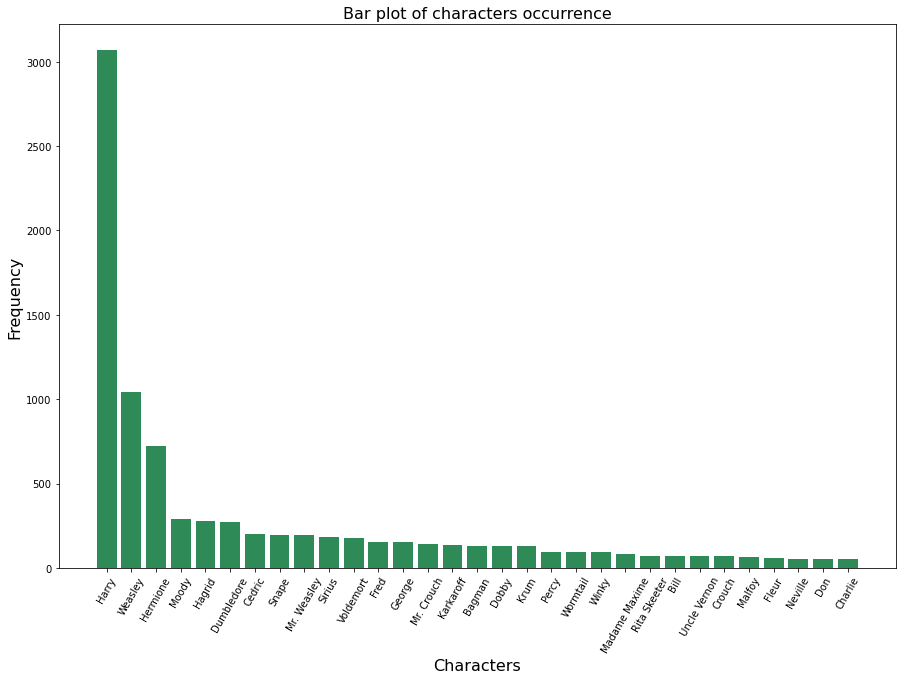

In [226]:
plt.figure(figsize=(15,10))
p = plt.bar(range(len(char_mentions_sorted)), char_mentions_sorted.values(), align='center', color='seagreen')
labels = plt.xticks(range(len(char_mentions_sorted)), list(char_mentions_sorted.keys()), rotation=60)
plt.title("Bar plot of characters occurrence", fontsize=16)
plt.xlabel('Characters', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

We see that the most frequent characters are: Harry, Ron Weasley and Hermione.

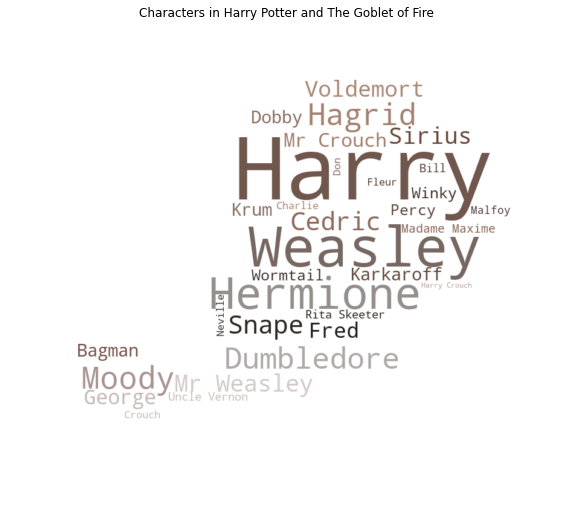

In [204]:
def word_cloud(text, image_name, maxsize,
               maxwords, title, figsize):
    stopwords = set(STOPWORDS)
    mask = np.array(Image.open(image_name))
    wordcloud = WordCloud(stopwords=stopwords,
                          background_color="white", max_words=maxwords, max_font_size=maxsize, mask=mask).generate(text)
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[figsize, figsize])
    plt.title(title)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()


mentions_dict = char_mentions
text = ""
for word, count in mentions_dict.items():
    text += (word+"  ")*count

text = text.split("  ")
random.shuffle(text)
text = "  ".join(text)

word_cloud(text, "harry_word.png",
          200, 70000, "Characters in Harry Potter and The Goblet of Fire", 10)

In [206]:
from IPython.display import Image
Image(url= "harry_word.png", width=400, height=400)

We define two functions for characters pair creating to visualize co-occurences.

In [227]:
mentioned_char_list = list(char_mentions.keys())

In [208]:
def filter_char(char_per_page, accepted):
    for page in char_per_page.keys():
        new_char = []
        [new_char.append(char) for char in char_per_page[page] if char in accepted]
        char_per_page[page] = list(set(new_char))
    return char_per_page

def get_char_pairs(accepted):
    char_dict = get_char_per_page()
    filter_char(char_dict, accepted)
    char_comb_list = []
    for page in char_dict.keys():
        if len(char_dict[page]) > 1:
            combinations = list(itertools.combinations(char_dict[page], 2))
            for pair in combinations:
                char_comb_list.append(list(pair))
    return dict(Counter(tuple(sorted(tup)) for tup in char_comb_list))

char_pairs = get_char_pairs(mentioned_char_list)

In [209]:
sorted_pairs = dict(sorted(char_pairs.items(), key=lambda item: item[1], reverse=True))
sorted_pairs

{('Harry', 'Weasley'): 380,
 ('Harry', 'Hermione'): 321,
 ('Hermione', 'Weasley'): 281,
 ('Dumbledore', 'Harry'): 127,
 ('Hagrid', 'Harry'): 95,
 ('Harry', 'Voldemort'): 91,
 ('Cedric', 'Harry'): 88,
 ('Harry', 'Moody'): 87,
 ('George', 'Harry'): 80,
 ('Fred', 'Harry'): 79,
 ('Harry', 'Sirius'): 79,
 ('Harry', 'Krum'): 74,
 ('Fred', 'George'): 72,
 ('Harry', 'Mr. Weasley'): 68,
 ('George', 'Weasley'): 67,
 ('Fred', 'Weasley'): 65,
 ('Harry', 'Mr. Crouch'): 62,
 ('Hagrid', 'Hermione'): 60,
 ('Hagrid', 'Weasley'): 60,
 ('Bagman', 'Harry'): 58,
 ('Harry', 'Snape'): 56,
 ('Harry', 'Karkaroff'): 55,
 ('George', 'Hermione'): 54,
 ('Harry', 'Madame Maxime'): 54,
 ('Fred', 'Hermione'): 53,
 ('Mr. Weasley', 'Weasley'): 50,
 ('Hermione', 'Sirius'): 49,
 ('Dumbledore', 'Weasley'): 48,
 ('Dumbledore', 'Hermione'): 48,
 ('Harry', 'Percy'): 48,
 ('Sirius', 'Weasley'): 47,
 ('Don', 'Harry'): 42,
 ('Krum', 'Weasley'): 42,
 ('Harry', 'Rita Skeeter'): 42,
 ('Moody', 'Weasley'): 41,
 ('Bill', 'Harry'): 4

In [214]:
G = nx.Graph()
sizes = []
for n in mentioned_char_list:
    G.add_node(n)
    sizes.append(char_mentions[n]*1)

for k, v in char_pairs.items():
    G.add_edge(k[0], k[1], weight=v)

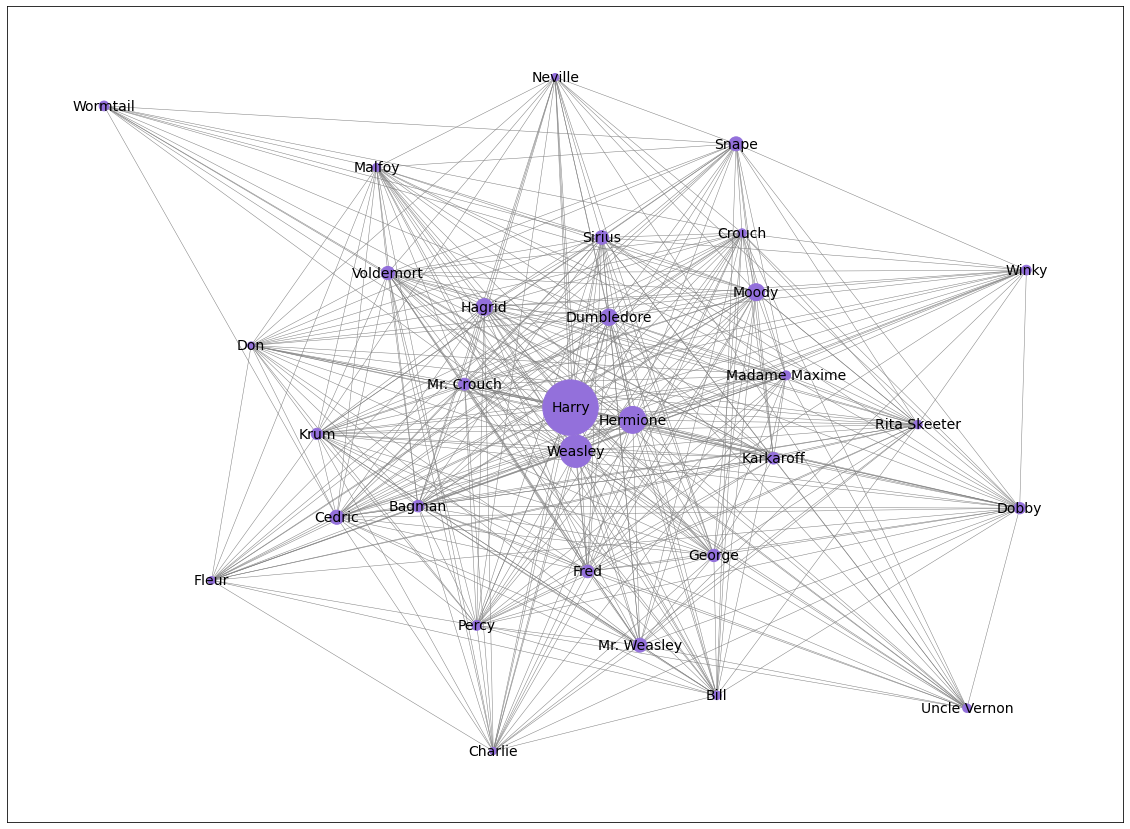

In [218]:
rcParams['figure.figsize'] = 20, 15
pos = nx.spring_layout(G, k=2, iterations=100, scale=2)
nx.draw_networkx(G, pos, with_labels=True, node_size=sizes, font_size=14,
                 node_color='mediumpurple', edge_color='grey', width=0.5)

As we can see there are three main characters in the center.

In [219]:
char_mentions2 = get_no_of_mentions(char_per_page, unit="book", n=150)
mentioned_char_list2 = list(char_mentions2.keys())
char_pairs2 = get_char_pairs(mentioned_char_list2)
sorted_pairs2 = dict(sorted(char_pairs2.items(), key=lambda item: item[1], reverse=True))

Next we will ilustrate the frequency of character pairs. 

Text(0, 0.5, 'Frequency')

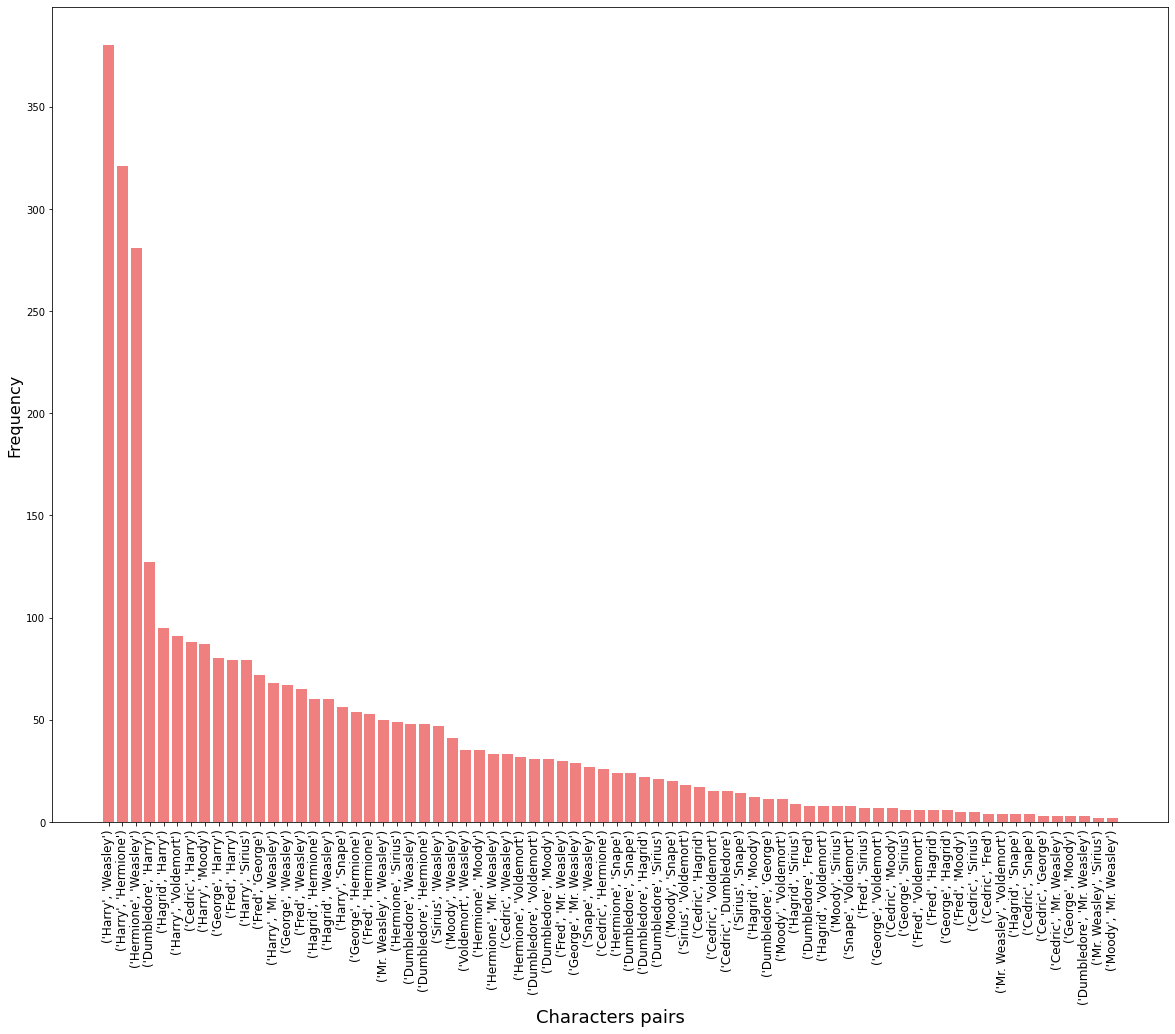

In [221]:
plt.figure(figsize=(20,15))
p = plt.bar(range(len(sorted_pairs2)), sorted_pairs2.values(), align='center', color='lightcoral')
labels = plt.xticks(range(len(sorted_pairs2)), list(sorted_pairs2.keys()), rotation=90, fontsize=12)
plt.xlabel('Characters pairs', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

In [224]:
G = nx.Graph()
for n in mentioned_char_list2:
    img = mpimg.imread(n + '.png')
    G.add_node(n, image=img)

for k, v in char_pairs2.items():
    G.add_edge(k[0], k[1], weight=v)

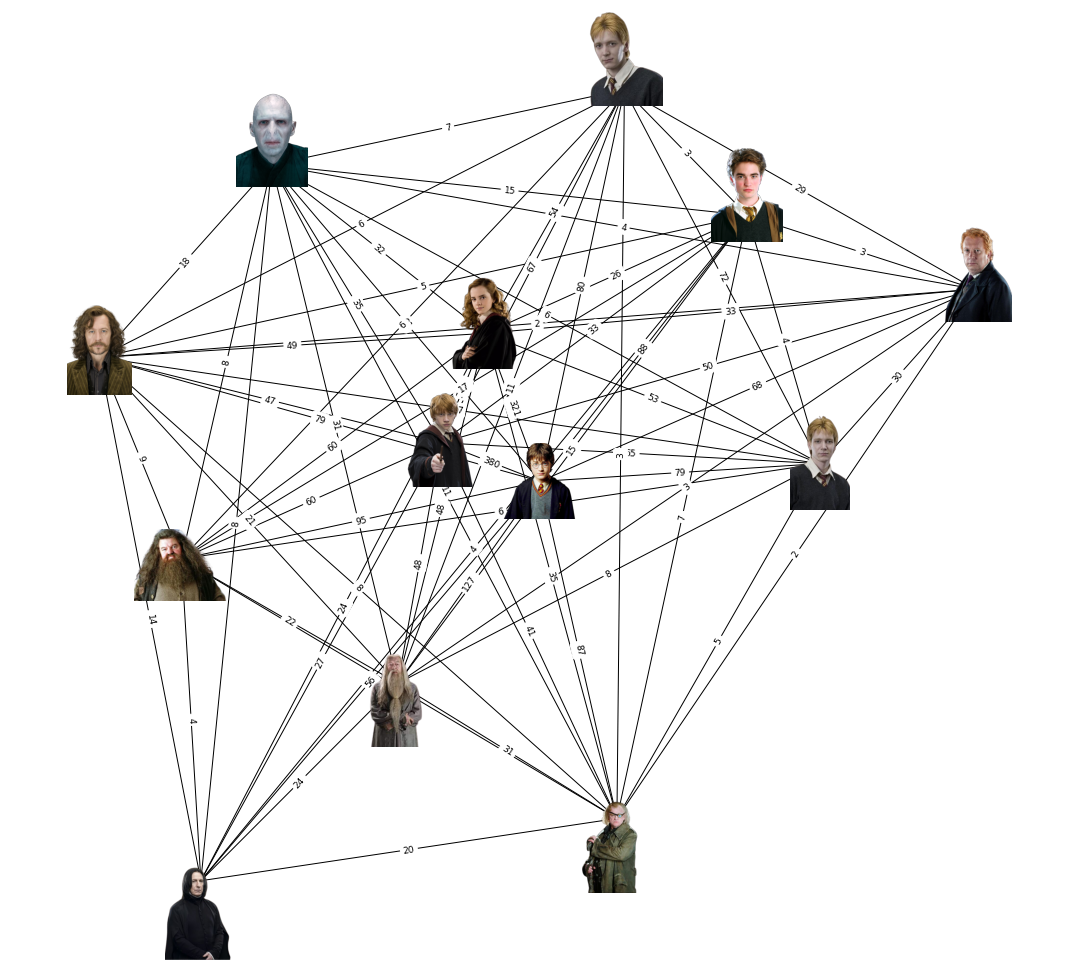

In [166]:
rcParams['figure.figsize'] = 19, 19
pos = nx.spring_layout(G, k=2, iterations=100, scale=2)

fig=plt.figure(figsize=(19,19))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx_edges(G,pos,ax=ax)
labels = nx.get_edge_attributes(G, 'weight')
p = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=9, label_pos=0.5)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.07
for n in G:
    xx,yy=trans(pos[n])
    xa,ya=trans2((xx,yy))
    a = plt.axes([xa-piesize/2.0, ya-piesize/2.0, piesize, piesize])
    a.set_aspect('equal')
    a.imshow(G.nodes[n]['image'])
    a.axis('off')
ax.axis('off')
plt.show()

## Summary

1. Using two different functions for sentiment analysis, we observe a big difference. Using the same libraries for Youtube comments data, differences were not that significant. 

2. We do not see a big difference between characters in neutral, positive and negative parts, because analisys id done on whole pages. 

3. As suspected, main characters are the cetral nodes.
